In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

In [2]:
# inverse homogeneous matrix fuction
from numpy.linalg import inv
def inv_homogenous_matrix(rvec, tvec):
    #https://mathematica.stackexchange.com/questions/106257/how-do-i-get-the-inverse-of-a-homogeneous-transformation-matrix
    rvec_out = inv(rvec)
    tvec_out = np.matmul(-1*rvec_out, tvec)
    return rvec_out, tvec_out

In [3]:
# image shifting function
def translate(image, x, y):
    M = np.float32([[1, 0, x], [0, 1, y]])
    shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    return shifted

In [4]:
# calculate rvec, tvec function

def extrinsic_from_coord(coord, inv = 0):
    
    roll, pitch, yaw = coord[3:6]

    Rx = [[1,            0,             0],
          [0, np.cos(roll), -np.sin(roll)],
          [0, np.sin(roll),  np.cos(roll)]]

    Ry = [[ np.cos(pitch), 0, np.sin(pitch)],
          [0             , 1,             0],
          [-np.sin(pitch), 0, np.cos(pitch)]]

    Rz = [[np.cos(yaw), -np.sin(yaw), 0],
          [np.sin(yaw),  np.cos(yaw), 0],
          [          0,            0, 1]]


    rvec = np.matmul( np.array(Rz), np.matmul(np.array(Ry), np.array(Rx)) ) #gazebo rotation order x->y->z
    tvec = np.array(coord[0:3])
    print(rvec, tvec)

    if inv:
        rvec, tvec = inv_homogenous_matrix(rvec, tvec)
        print(rvec, tvec)

    trivial_row = np.array([0, 0, 0, 1]).reshape((1, 4))
    extrinsic = np.append(rvec, tvec.reshape((3, 1)), axis=1)
    extrinsic = np.append(extrinsic, trivial_row, axis=0)

    return extrinsic

In [5]:
# object and camera information setting

# model_name
obj_name = ['chimp', 'drill', 'egg', 'iron', 'waterer']

# select which image and model you want to map
'''change me'''
img_idx = 3
target_object_idx = 1

# get target file name
image_names = os.listdir("fov1.019/rgb")
test_image = "fov1.019/rgb/{}".format(image_names[img_idx])
print("testing image: ", test_image)

# object coords from .world sdf file
obj_pos = [
    [-0.163166, -0.205481, 1.015, 0,  0, -2.03728],
    [-0.050155, -0.150925, 1.015, 0, -0, 0],
    [-0.01794 , -0.272658, 1.015, 0, -0, 0],
    [ 0.095093, -0.144745, 1.015, 0,  0, -1.2067],
    [-0.114063, -0.040276, 1.015, 0,  0, -0.874424]
]

# read camera position from script
f = open("camera_script.txt")
cam_pos = f.readlines()[img_idx].split(',')
cam_pos = [float(cam_pos[0]), float(cam_pos[1]), float(cam_pos[2])]
point_at = [-0.05, -0.15, 1.01, 1.0]

# calculates whole 6D pose of the camera from pointing direction
dx = point_at[0] - cam_pos[0]
dy = point_at[1] - cam_pos[1]
dz = point_at[2] - cam_pos[2]
base = np.sqrt(np.sum(np.square([dx, dy])))
yaw = np.arctan2(dy,dx)
pitch = -1.0*np.arctan2(dz,base)
rotation = [0.0, pitch, yaw]
cam_pos = cam_pos + rotation


print("mapping model '{}' to image '{}'".format(obj_name[target_object_idx], test_image))
print("camera pose: ", cam_pos)
print("object pose: ", obj_pos[target_object_idx])

testing image:  fov1.019/rgb/0003.png
mapping model 'drill' to image 'fov1.019/rgb/0003.png'
camera pose:  [-0.114093165291, -0.0476354767453, 1.50952814436, 0.0, 1.3335720415677976, -1.01138718134811]
object pose:  [-0.050155, -0.150925, 1.015, 0, 0, 0]


point count:  12655
model z offset: -0.103882
[[ 3.33595e-02 -8.37000e-04 -8.54868e-02  1.00000e+00]
 [ 1.88245e-02 -8.53940e-03 -1.02907e-01  1.00000e+00]
 [ 8.03540e-03  2.69976e-02 -8.55054e-02  1.00000e+00]
 ...
 [ 3.97267e-02  2.79776e-02  7.69421e-02  1.00000e+00]
 [ 1.87624e-02  2.69710e-02  8.42011e-02  1.00000e+00]
 [ 5.00583e-02  2.40637e-02  8.53271e-02  1.00000e+00]]
z min:  -0.103882
z max:  0.103908


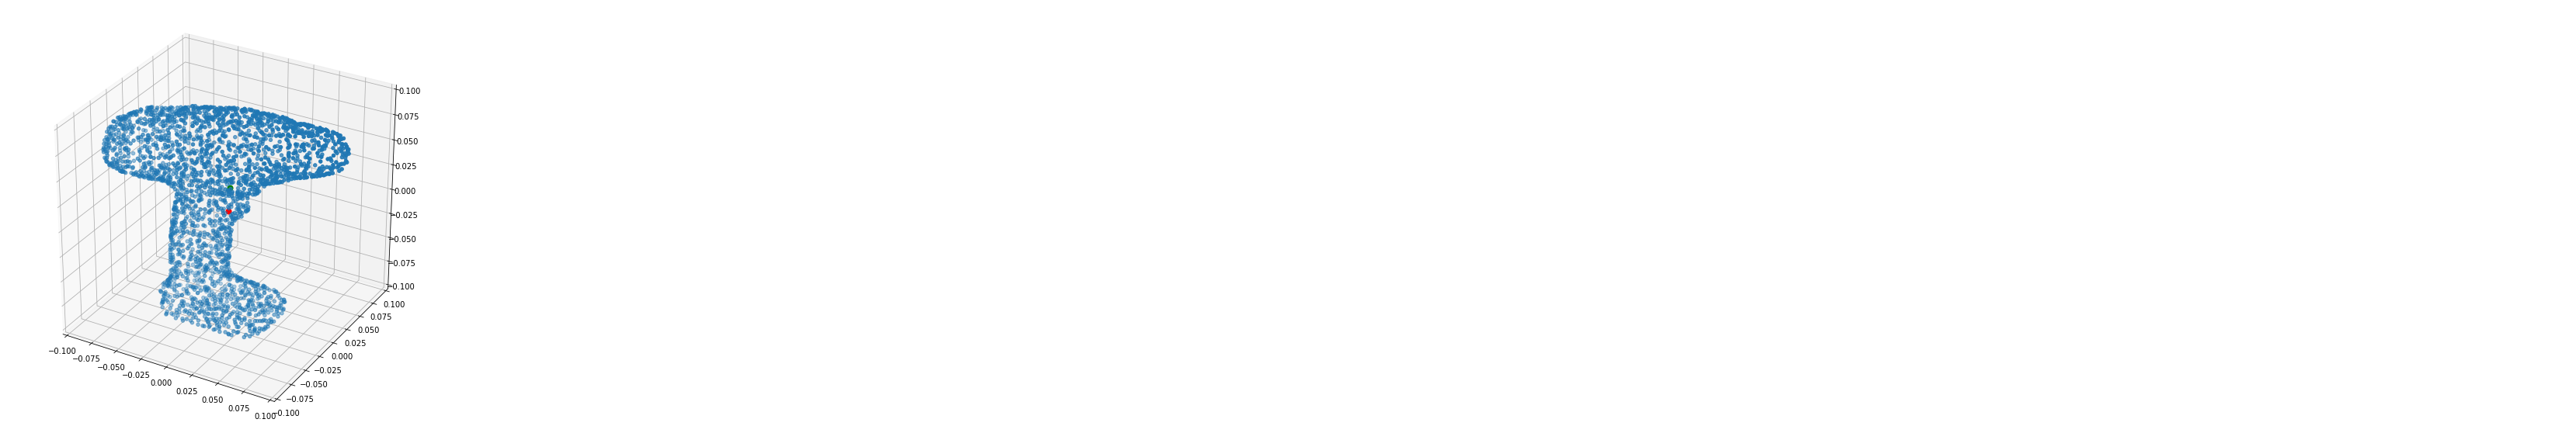

In [6]:
# read points from model.ply
model_path = "models/{}.ply".format(obj_name[target_object_idx])
f = open(model_path)
lines = f.readlines()

points = []
point_num = int(lines[3].split()[-1])
print("point count: ", point_num)

sample_rate = 5

closest_point_to_zero = np.array([1000.0, 1000.0, 1000.0])

for idx, line in enumerate(lines[17:17+point_num]):

    if idx % sample_rate == 0:
        x, y, z = line.split(' ')[:3]
        x = float(x)/1000
        y = float(y)/1000
        z = float(z)/1000
        # you need to shift all model points cuz zero is not at the bottom of your model
        # gazebo uses model bottom as zero point
        points.append([x, y, z, 1.0])
        if(x**2+y**2+z**2 < np.sum(closest_point_to_zero**2)):
            closest_point_to_zero[0] = x
            closest_point_to_zero[1] = y
            closest_point_to_zero[2] = z

points = np.array(points)

# shift in z direction to move model refernce point to the bottom of model
model_zoffset = np.min(points[:, 2])
#points[:, 2] -= model_zoffset
print("model z offset:", model_zoffset)
print(points)
print("z min: ", np.min(points[:, 2]))
print("z max: ", np.max(points[:, 2]))


# show model on plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10)) # specify figsize or your image will be distorted

ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.scatter(0, 0, 0, c = 'red', s = 50)
ax.scatter(0.000559, 0.001484, 0.022542000000000003, c = 'green', s = 50)
ax.set_xlim3d(-0.1, 0.1)
ax.set_ylim3d(-0.1, 0.1)
ax.set_zlim3d(-0.1, 0.1)
plt.show()

In [7]:
# set camera coord and object coord
print("mapping target: ", obj_name[target_object_idx])

camera_coord = np.array(cam_pos)
object_coord = np.array(obj_pos[target_object_idx])

# gazebo and model using model bottom as z reference point
object_coord[2] -= model_zoffset

print("camera at: ", camera_coord)
print("object at: ", object_coord)

mapping target:  drill
camera at:  [-0.11409317 -0.04763548  1.50952814  0.          1.33357204 -1.01138718]
object at:  [-0.050155 -0.150925  1.118882  0.        0.        0.      ]


In [8]:
# calculate object_to_world and world_to_camera extrinsics

world_to_cam_extrinsic = extrinsic_from_coord(camera_coord, inv = 1)
object_to_world_extrinsic = extrinsic_from_coord(object_coord)

print(world_to_cam_extrinsic)
print(object_to_world_extrinsic)

[[ 0.12471404  0.84756882  0.51582314]
 [-0.19918338  0.5306855  -0.82383183]
 [-0.97199403  0.          0.23500556]] [-0.11409317 -0.04763548  1.50952814]
[[ 1.24714042e-01 -1.99183382e-01 -9.71994027e-01]
 [ 8.47568817e-01  5.30685501e-01  3.27472827e-17]
 [ 5.15823137e-01 -8.23831827e-01  2.35005557e-01]] [ 1.47199316  0.12198127 -0.33513923]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [-0.050155 -0.150925  1.118882]
[[ 1.24714042e-01 -1.99183382e-01 -9.71994027e-01  1.47199316e+00]
 [ 8.47568817e-01  5.30685501e-01  3.27472827e-17  1.21981266e-01]
 [ 5.15823137e-01 -8.23831827e-01  2.35005557e-01 -3.35139230e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.        0.        0.       -0.050155]
 [ 0.        1.        0.       -0.150925]
 [ 0.        0.        1.        1.118882]
 [ 0.        0.        0.        1.      ]]


In [9]:
# combine object_to_world extrinsic and world_to_camera extrinsic

rot_to_cam = np.array([[ 0,-1, 0, 0],
                       [ 0, 0,-1, 0],
                       [ 1, 0, 0, 0],
                       [ 0, 0, 0, 1]])

'''
    combined extrinsic = rot_to_cam * world_to_cam * object_to_world
'''
combined_extrinsic = np.matmul(world_to_cam_extrinsic, object_to_world_extrinsic)
combined_extrinsic = np.matmul(rot_to_cam, combined_extrinsic)
print(combined_extrinsic)

[[-8.47568817e-01 -5.30685501e-01 -3.27472827e-17  6.22257255e-04]
 [-5.15823137e-01  8.23831827e-01 -2.35005557e-01 -2.62699669e-02]
 [ 1.24714042e-01 -1.99183382e-01 -9.71994027e-01  4.08253262e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [10]:
# transform model points coords to camera frame coords
points_cam_frame = np.matmul(combined_extrinsic, points.transpose())
print(points_cam_frame.transpose()[:, 0:3])

[[-0.02720803 -0.02407724  0.49567304]
 [-0.01080107 -0.01883139  0.51232684]
 [-0.02051553  0.01192091  0.48698865]
 ...
 [-0.04789616 -0.0417949   0.33284781]
 [-0.02959329 -0.03351621  0.32337806]
 [-0.05457585 -0.0523191   0.32676571]]


In [11]:
# set camera intrinsic
synth_intrinsic = [572.411400033838, 0.0, 320.0, 0.0, 572.4114000338382, 240, 0.0, 0.0, 1.0] #from hFOV
real_intrinsic = [572.4114, 0.0, 325.2611, 0.0, 640.57043, 270.04899, 0.0, 0.0, 1.0] # from linemod dataset

synth_intrinsic = np.array(synth_intrinsic).reshape((3, 3))
real_intrinsic = np.array(real_intrinsic).reshape((3, 3))

intrinsic = real_intrinsic # specify which intrinsic you want to test

print(intrinsic)

[[572.4114    0.      325.2611 ]
 [  0.      640.57043 270.04899]
 [  0.        0.        1.     ]]


In [12]:
# points xyz to camera pixel position
pixel_coord = np.matmul(intrinsic, points_cam_frame[0:3, :])
print(pixel_coord.transpose())

[[145.64896986 118.43283283   0.49567304]
 [160.45733743 126.29051211   0.51232684]
 [146.655141   139.14697939   0.48698865]
 ...
 [ 80.84613438  63.11263549   0.33284781]
 [ 88.24276762  65.85842747   0.32337806]
 [ 75.04433509  54.72868479   0.32676571]]


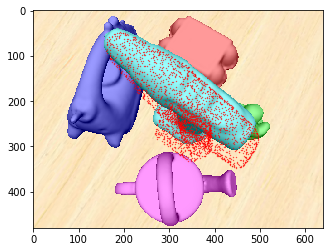

In [13]:
# before image shifting and streching
img = Image.open(test_image)
img = np.array(img) 

plt.imshow(img)
for row in pixel_coord.transpose():
    row[0] /= row[2]
    row[1] /= row[2]
    row[2] /= row[2]
    if abs(row[0]) < 1000:
        plt.scatter([row[0]], [row[1]], s = 0.1, c = 'red')
plt.show()
#plt.savefig('result/mapping result.png')

In [14]:
img = Image.open(test_image)
img = np.array(img) 

In [15]:
#模擬不同內參的影像
def simulate_intrinsic(img, original_intrinsic, target_intrinsic):
    w, h = img.shape[1], img.shape[0]
    new_w = (target_intrinsic[0,0] / original_intrinsic[0,0]) * w
    new_h = (target_intrinsic[1,1] / original_intrinsic[1,1]) * h
    #image streching
    img = cv2.resize(img, (int(new_w), int(new_h)), interpolation=cv2.INTER_CUBIC)
    img = img[int(new_h/2-h/2):int(new_h/2+h/2), int(new_w/2-w/2):int(new_w/2+w/2)]
    print(img.shape)
    
    # image shifting
    u_shift = int(target_intrinsic[0,2] - original_intrinsic[0,2])
    v_shift = int(target_intrinsic[1,2] - original_intrinsic[1,2])
    #print()
    img = translate(img, u_shift, v_shift)
    return img
    

(480, 639, 3)


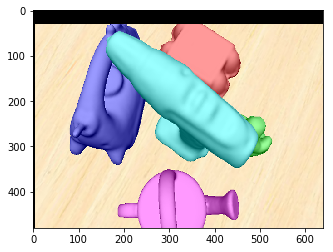

In [16]:
img = simulate_intrinsic(img, synth_intrinsic, real_intrinsic)
plt.imshow(img)

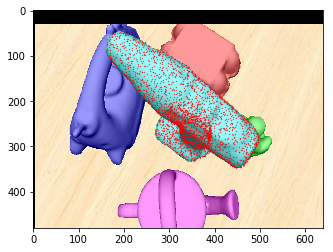

In [17]:
plt.imshow(img)
for row in pixel_coord.transpose():
    row[0] /= row[2] # height
    row[1] /= row[2] # width
    row[2] /= row[2]
    #print(row)
    if row[1] < 480 and row[1] >= 0 and row[0] < 640 and row[0] >=0:
        #pass
        plt.scatter([row[0]], [row[1]], s = 0.1, c = 'red')
plt.show()
#plt.savefig('result/mapping result.png')